# Import библиотек

In [0]:
from tensorflow.keras.models import Model,Sequential # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import numpy as np # Импортируем библиотеку numpy
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
import PIL
import time,cv2,math
from keras.preprocessing.image import save_img
from random import randrange
import numpy.random as random
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Flatten


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!nvidia-smi


Thu Apr  2 08:07:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Загрузка массивов изображений

In [0]:
images_planes = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
directory_planes = '/content/drive/My Drive/Базы/Самолеты/Самолеты' # Указываем путь к обучающей выборке с оригинальными изображения
for filename in os.listdir(directory_planes): # Проходим по всем файлам в каталоге по указанному пути 
  if filename!='.ipynb_checkpoints':
    images_planes.append(image.load_img(os.path.join(directory_planes,filename), target_size=(135, 240))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size


In [0]:
images_sky = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
directory = '/content/drive/My Drive/Базы/Небо/Небо' # Указываем путь к обучающей выборке с изображениями неба
for filename in os.listdir(directory): # Проходим по всем файлам в каталоге по указанному пути 
  if filename!= 'Самолеты' and filename!='planes'  and filename!='.ipynb_checkpoints':
    images_sky.append(image.load_img(os.path.join(directory,filename), target_size=(135, 240))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size


In [0]:
images_Bplanes = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
directory = '/content/drive/My Drive/Базы/Небо/итог' # Указываем путь к обучающей выборке с изображениями немного прикрытых самолетов
for filename in os.listdir(directory): # Проходим по всем файлам в каталоге по указанному пути 
    images_Bplanes.append(image.load_img(os.path.join(directory,filename), target_size=(135, 240))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size


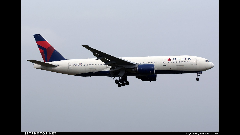

In [0]:
n=15
images_planes[n]

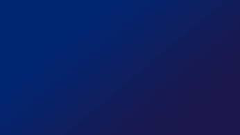

In [0]:
images_sky[n]

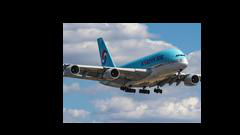

In [0]:
images_Bplanes[n]

# Создаем обучающую выборку

In [0]:
x =[] # здесь будут по порядку лежать массивы:

# Изображений неба
for i in range(len(images_sky)):
  x.append(image.img_to_array(images_sky[i]))
# Изображений самолетов
for i in range(len(images_planes)):
  x.append(image.img_to_array(images_planes[i]))
# Изображений прикрытых самолетов
for i in range(len(images_Bplanes)):
  x.append(image.img_to_array(images_Bplanes[i]))

In [0]:
y = [] # здесь будут в том же порядке лежать лейблы:

# "Нет самолета"
for i in range(len(images_sky)):
  y.append(0)
# "Есть самолет"
for i in range(len(images_planes)):
  y.append(1)
# "Нет самолета"
for i in range(len(images_Bplanes)):
  y.append(0)

In [0]:
# Функция для перемешивания выборки (x,y) в том же порядке
def unison_shuffled_copies(a, b):
    assert len(a) == len(b) # проверка, если той же длины
    p = np.random.permutation(len(a)) # генерируем комбинации индексов
    return a[p], b[p] # на выходе перемешанные массивы

x = np.array(x)
y = np.array(y)

x1,y1 = unison_shuffled_copies(x/255, y) # на вход для х подаем нормализованные (0..255) массивы

In [0]:
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(135,240, 3)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, (5, 5), padding='same', activation='linear'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [0]:
history = model.fit(x1,y1,epochs=20, batch_size=30,validation_split=0.2,verbose=1)

Epoch 1/20
61/61 [==============================] - 4s 67ms/step - loss: 0.2730 - accuracy: 0.9088 - val_loss: 0.1764 - val_accuracy: 0.9408
Epoch 2/20
61/61 [==============================] - 3s 56ms/step - loss: 0.0920 - accuracy: 0.9703 - val_loss: 0.1395 - val_accuracy: 0.9671
Epoch 3/20
61/61 [==============================] - 3s 56ms/step - loss: 0.0622 - accuracy: 0.9841 - val_loss: 0.1106 - val_accuracy: 0.9649
Epoch 4/20
61/61 [==============================] - 3s 56ms/step - loss: 0.0501 - accuracy: 0.9846 - val_loss: 0.0951 - val_accuracy: 0.9737
Epoch 5/20
61/61 [==============================] - 3s 56ms/step - loss: 0.0327 - accuracy: 0.9923 - val_loss: 0.0643 - val_accuracy: 0.9781
Epoch 6/20
61/61 [==============================] - 3s 56ms/step - loss: 0.0232 - accuracy: 0.9934 - val_loss: 0.0712 - val_accuracy: 0.9846
Epoch 7/20
61/61 [==============================] - 3s 56ms/step - loss: 0.0225 - accuracy: 0.9929 - val_loss: 0.0755 - val_accuracy: 0.9781
Epoch 8/20
61

In [0]:
Plane = PIL.Image.open('/content/drive/My Drive/Базы/Самолеты/Самолеты'+'/'+'airplane_15.jpg').convert('RGB')
Plane = Plane.resize((240, 135),Image.ANTIALIAS)
draw = image.img_to_array(Plane)


In [0]:
def filterImg(oper):
  regions = []
  merge = 120
  i=0
  j=0
  IMpl = oper.copy()
  region = []
  ribb = []

  for i in range(1,IMpl.shape[0]):
    for j in range(1,IMpl.shape[1]):
      for k in range(IMpl.shape[2]):
        delta = IMpl[i-1,j-1,k]-IMpl[i,j,k]
     # print(delta)
        if delta>merge:
      #ribb.append(img[i-3:i,j-3:j,0])
          IMpl[i,j,k] = 255
          regions.append([[i-1],[j-1]])
      
        else:
          IMpl[i-1:i+1,j-1:j+1,k] = 0
          regions.append([[i-1],[j-1]])

  return regions, IMpl.astype('uint8')
#Image.fromarray(img.astype('uint8'))  


#v1

In [0]:
'''
    Функция получения выжившей популяции
        Входные параметры:
        - popul - наша популяция
        - val - текущие значения
        - nsurv - количество выживших
        - reverse - указываем требуемую операцию поиска результата: максимизация или минимизация
'''
def getSurvPopul(
        popul,
        val,
        nsurv,
        reverse
        ):
    newpopul = [] # Двумерный массив для новой популяции

    sval= sorted(val, reverse=reverse) # Сортируем зачения в val в зависимости от параметра reverse
    for i in range(nsurv): # Проходимся по циклу nsurv-раз (в итоге в newpopul запишется nsurv-лучших показателей)
        index = val.index(sval[i]) # Получаем индекс i-того элемента sval в исходном массиве val
        newpopul.append(popul[index]) # В новую папуляцию добавляем элемент из текущей популяции с найденным индексом

    #newpopul = [] # Двумерный массив для новой популяции

   # sval2= sorted(sval, reverse=reverse-1,key = lambda x: x[1]) # Сортируем зачения в val в зависимости от параметра reverse
   # for i in range(nsurv): # Проходимся по циклу nsurv-раз (в итоге в newpopul запишется nsurv-лучших показателей)
    #    index = sval.index(sval2[i]) # Получаем индекс i-того элемента sval в исходном массиве val
      #  print(len(newpopul),index)
     #   newpopul.append(popul[index]) # В новую популяцию добавляем элемент из текущей популяции с найденным индексом

    return newpopul, sval # Возвращаем новую популяцию (из nsurv элементов) и сортированный список
    
'''
    Функция получения родителей
        Входные параметры:
        - curr_popul - текущая популяция
        - nsurv - количество выживших
'''
def getParents(
        curr_popul,
        nsurv
        ):   
    indexp1 = random.randint(0, nsurv - 1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0, nsurv - 1) # Случайный индекс второго родителя в диапазоне от 0 до nsurv - 1    
    botp1 = curr_popul[indexp1] # Получаем первого бота-родителя по indexp1
    botp2 = curr_popul[indexp2] # Получаем второго бота-родителя по indexp2 

    return botp1,botp2 # Возвращаем обоих полученных ботов

'''
    Функция смешивания (кроссинговера) двух родителей
        Входные параметры:
        - botp1 - первый бот-родитель
        - botp2 - второй бот-родитель
        - j - номер компонента бота
'''
def crossPointFrom2Parents(
        botp1,
        botp2,
        i,
        ):
    pindex = np.random.random() # Получаем случайное число в диапазоне от 0 до 1
    
     #Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
    if pindex < 0.5:
        x = botp1[i]
    else:
        x = botp2[i]
    return x # Возвращаем значние бота

'''
    Функция, зануляющая пиксели 
    вне границ прямоугольника,
    координаты которого заложены в боте.

'''

def masked(img_array, bot): 
  mask = img_array.copy() # копируем массив-картинку

  # проходимся по каждому пикселю
  for i in range(mask.shape[1]): 
    for j in range(mask.shape[0]):
      if (j in range(bot[1],bot[1]+bot[2])) and( i in range(bot[0],bot[0]+bot[3])): # если текущий пиксель в пределах координат бота
        continue # ничего не делаем
      else: # иначе зануляем (делаем черным)
        mask[j,i]=0

  return mask # возвращаем изображение с маской

'''
    Функция расчета вознаграждения за эпизод
        Входные параметры:
        - popul - популяция ботов
'''
def countValue(
    popul
    ):
  
  score_list=[]

  for bot in popul: # проходимся по каждому боту в популяции

    draw = image.img_to_array(plane)/255 # нормализуем картинку-массив
    img1 = masked(draw,bot) # накладываем маску
    start = time.time() # засекаем время
    scores = model.predict(np.expand_dims(img1,0)) # делаем предсказание по картинке с маской
    delta=abs(bot[2]*bot[3]) # считаем площадь прямоугольника
    multi=scores**2-round(np.log(delta/(240*135)+1)) # функция, по которой будем выбирать лучшего бота
    score_list.append(multi) # заносим это значение в массив

  return score_list

In [0]:
l=0 # счетчик для названия, под которым сохраняем изображение. 
n = 70 # популяция
nsurv = 30 # количество выживших
nnew = n-nsurv # количество новых
mut = 0.2 # коэфициент мутаций

for name in os.listdir(directory_planes): # проходимся по папке с картинками самолетов
  plane = PIL.Image.open(directory_planes+"/"+name).convert('RGB') # открываем картинку
  plane = plane.resize((240, 135),Image.ANTIALIAS) # меняем размер картинки с помощью афинного преобразования

  popul=[] # здесь будут лежать боты

  for i in range(n): # создаем популяцию
    h = np.random.randint(68) # ширина прямоугольника
    w = np.random.randint(120) # высота прямоугольника
    bot = [np.random.randint(240),np.random.randint(135),h,w] # список координат: [x,y,h,w]
    popul.append(bot) #

  curr_time = time.time() # будем измерять время расчета
  sval =[0] # начальное значение максимального результата для запуска цикла
  it=0 # будем следать сколько итераций уходит на каждую популяцию
  while sval[0]<0.9: # пока точность не будет больше 90% 
    if it>100: break # если количество итераций не превышает 100 (эволюция не застряла на минимальном результате)
    else:
      val = countValue(popul) # считаем результат для текущей популяции
      newpopul, sval = getSurvPopul(popul, val, nsurv,1) # получили популяцию выживших
      print(it, time.time() - curr_time, " ", sval[0:3],popul[:3]) # Выводим время на операцию, среднее значение и 20 лучших ботов  
      curr_time = time.time() # Обновляем текущее время
      it+=1 

      # проходимся по новой популяции
      for k in range(nnew):

        # вытаскиваем новых родителей
        botp1, botp2 = getParents(newpopul, nsurv)
        newbot = [] # здесь будет новый бот

        for i in range(4): # проходимся по длине бота

          x = crossPointFrom2Parents(botp1, botp2,i) # скрещиваем
          if random.random()<mut: # если меньше коэф мутации
            x+=random.choice([-1,1])*random.randint(1,10) # добавляем случайную величину из [1,10] случайного знака
            if i<2 and x<0: x = abs(x) # если у нас координаты на плоскости отрицательные, то берем их абсолютное значение

          newbot.append(x) # закидываем элемент в бота
        newpopul.append(newbot) # добавляем бота
      popul = newpopul # вывести список на эпоху
  l+=1

  draw = image.img_to_array(plane)/255 # нормализуем текущий массив
  maska = masked(draw,popul[0]) # закрываем лучшим ботом область, где самолета нет

  save_img(('/content/drive/My Drive/Базы/Небо/present_squares/{}.jpg').format(l),maska*255) # сохраняем картинку с обычными значениями RGB
  save_img(('k/{}.jpg').format(l),maska*255)
  
  print(l) # печатаем текущую сохраненную картинку


Streaming output truncated to the last 5000 lines.
91 3.1881728172302246   [array([[1.3983908e-09]], dtype=float32), array([[1.1316267e-09]], dtype=float32), array([[1.1316267e-09]], dtype=float32)] [[61, 82, 48, 151], [61, 82, 48, 151], [62, 82, 48, 155]]
92 3.2042925357818604   [array([[1.4779528e-09]], dtype=float32), array([[1.4170669e-09]], dtype=float32), array([[1.3983908e-09]], dtype=float32)] [[60, 75, 56, 154], [61, 82, 48, 151], [61, 82, 48, 151]]
93 3.170038938522339   [array([[2.6304305e-09]], dtype=float32), array([[1.4779528e-09]], dtype=float32), array([[1.4721516e-09]], dtype=float32)] [[62, 73, 56, 154], [56, 82, 48, 160], [60, 75, 56, 154]]
94 3.225355386734009   [array([[2.6304305e-09]], dtype=float32), array([[1.4779528e-09]], dtype=float32), array([[1.4779528e-09]], dtype=float32)] [[60, 74, 56, 154], [62, 73, 56, 154], [62, 73, 56, 148]]
95 3.155378818511963   [array([[2.6304305e-09]], dtype=float32), array([[2.1799709e-09]], dtype=float32), array([[1.4846686e-09

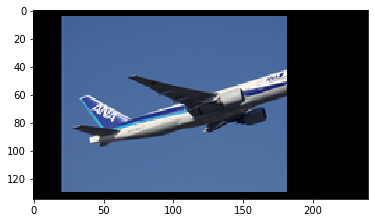

In [0]:
draw = image.img_to_array(plane)/255
maska =masked(draw,popul[0])
plt.imshow(maska)

#v2

In [0]:
'''
    Функция получения выжившей популяции
        Входные параметры:
        - popul - наша популяция
        - val - текущие значения
        - nsurv - количество выживших
        - reverse - указываем требуемую операцию поиска результата: максимизация или минимизация
'''
def getSurvPopul(
        popul,
        val,
        nsurv,
        reverse
        ):
    newpopul = [] # Двумерный массив для новой популяции

    sval= sorted(val, reverse=reverse) # Сортируем зачения в val в зависимости от параметра reverse
    for i in range(nsurv): # Проходимся по циклу nsurv-раз (в итоге в newpopul запишется nsurv-лучших показателей)
        index = val.index(sval[i]) # Получаем индекс i-того элемента sval в исходном массиве val
        newpopul.append(popul[index]) # В новую папуляцию добавляем элемент из текущей популяции с найденным индексом

    #newpopul = [] # Двумерный массив для новой популяции

   # sval2= sorted(sval, reverse=reverse-1,key = lambda x: x[1]) # Сортируем зачения в val в зависимости от параметра reverse
   # for i in range(nsurv): # Проходимся по циклу nsurv-раз (в итоге в newpopul запишется nsurv-лучших показателей)
    #    index = sval.index(sval2[i]) # Получаем индекс i-того элемента sval в исходном массиве val
      #  print(len(newpopul),index)
     #   newpopul.append(popul[index]) # В новую популяцию добавляем элемент из текущей популяции с найденным индексом

    return newpopul, sval # Возвращаем новую популяцию (из nsurv элементов) и сортированный список
    
'''
    Функция получения родителей
        Входные параметры:
        - curr_popul - текущая популяция
        - nsurv - количество выживших
'''
def getParents(
        curr_popul,
        nsurv
        ):   
    indexp1 = random.randint(0, nsurv - 1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0, nsurv - 1) # Случайный индекс второго родителя в диапазоне от 0 до nsurv - 1    
    botp1 = curr_popul[indexp1] # Получаем первого бота-родителя по indexp1
    botp2 = curr_popul[indexp2] # Получаем второго бота-родителя по indexp2 

    return botp1,botp2 # Возвращаем обоих полученных ботов

'''
    Функция смешивания (кроссинговера) двух родителей
        Входные параметры:
        - botp1 - первый бот-родитель
        - botp2 - второй бот-родитель
        - j - номер компонента бота
'''
def crossPointFrom2Parents(
        botp1,
        botp2,
        i,
        ):
    pindex = np.random.random() # Получаем случайное число в диапазоне от 0 до 1
    
     #Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
    if pindex < 0.5:
        x = botp1[i]
    else:
        x = botp2[i]
    return x # Возвращаем значние бота

'''
    Функция, зануляющая пиксели 
    вне границ прямоугольника,
    координаты которого заложены в боте.

'''

def masked(img_array, bot): 
  mask = img_array.copy() # копируем массив-картинку

  # проходимся по каждому пикселю
  for i in range(mask.shape[1]): 
    for j in range(mask.shape[0]):
      if (j in range(bot[1],bot[1]+bot[2])) and( i in range(bot[0],bot[0]+bot[3])): # если текущий пиксель в пределах координат бота
        continue # ничего не делаем
      else: # иначе зануляем (делаем черным)
        mask[j,i]=0

  return mask # возвращаем изображение с маской

'''
    Функция расчета вознаграждения за эпизод
        Входные параметры:
        - popul - популяция ботов
'''
def countValue(
    popul
    ):
  
  score_list=[]

  for bot in popul: # проходимся по каждому боту в популяции

    draw = image.img_to_array(plane)/255 # нормализуем картинку-массив
    img1 = masked(draw,bot) # накладываем маску
    start = time.time() # засекаем время
    scores = model.predict(np.expand_dims(img1,0)) # делаем предсказание по картинке с маской
    delta=abs(bot[2]*bot[3]) # считаем площадь прямоугольника
    multi=scores**2-round(round(np.log(delta/(240*135)+1))) # функция, по которой будем выбирать лучшего бота
    score_list.append(multi) # заносим это значение в массив

  return score_list

In [0]:
l=0 # счетчик для названия, под которым сохраняем изображение. 
n = 70 # популяция
nsurv = 30 # количество выживших
nnew = n-nsurv # количество новых
mut = 0.2 # коэфициент мутаций

for name in os.listdir(directory_planes): # проходимся по папке с картинками самолетов
  plane = PIL.Image.open(directory_planes+"/"+name).convert('RGB') # открываем картинку
  plane = plane.resize((240, 135),Image.ANTIALIAS) # меняем размер картинки с помощью афинного преобразования
  draw = image.img_to_array(plane)
#  laplacian = cv2.Laplacian(draw[:,:,0].astype('uint8'),cv2.CV_8UC1,3,3)
 # laplacian=laplacian.reshape(135,240,1)

  sobel = cv2.Sobel(draw,cv2.CV_8UC1,1,1,ksize=5)
  regions,IMplane = filterImg(sobel)
  regions = np.array(regions)
  popul=[] # здесь будут лежать боты

  for i in range(n): # создаем популяцию

    h = abs(np.random.choice(regions[:,0,:].reshape(-1,))-np.random.choice(regions[:,0,:].reshape(-1,))) # ширина прямоугольника
    w =  abs(np.random.choice(regions[:,1,:].reshape(-1,))-np.random.choice(regions[:,1,:].reshape(-1,)))# высота прямоугольника
    bot = [np.random.choice(regions[:,0,:].reshape(-1,)),np.random.choice(regions[:,1,:].reshape(-1,)),h,w] # список координат: [x,y,h,w]
    popul.append(bot) #

  curr_time = time.time() # будем измерять время расчета
  sval =[0] # начальное значение максимального результата для запуска цикла
  it=0 # будем следать сколько итераций уходит на каждую популяцию
  while sval[0]<0.98: # пока точность не будет больше 90% 
    if it>100: break # если количество итераций не превышает 100 (эволюция не застряла на минимальном результате)
    else:
      val = countValue(popul) # считаем результат для текущей популяции
      newpopul, sval = getSurvPopul(popul, val, nsurv,1) # получили популяцию выживших
      print(it, time.time() - curr_time, " ", sval[0:3],popul[:3]) # Выводим время на операцию, среднее значение и 20 лучших ботов  
      curr_time = time.time() # Обновляем текущее время
      it+=1 

      # проходимся по новой популяции
      for k in range(nnew):

        # вытаскиваем новых родителей
        botp1, botp2 = getParents(newpopul, nsurv)
        newbot = [] # здесь будет новый бот

        for i in range(4): # проходимся по длине бота

          x = crossPointFrom2Parents(botp1, botp2,i) # скрещиваем
          if random.random()<mut: # если меньше коэф мутации
            x+=random.choice([-1,1])*random.randint(1,10) # добавляем случайную величину из [1,10] случайного знака
            if i<2 and x<0: x = abs(x) # если у нас координаты на плоскости отрицательные, то берем их абсолютное значение

          newbot.append(x) # закидываем элемент в бота
        newpopul.append(newbot) # добавляем бота
      popul = newpopul # вывести список на эпоху
  l+=1

  draw = image.img_to_array(plane)/255 # нормализуем текущий массив
  maska = masked(draw,popul[0]) # закрываем лучшим ботом область, где самолета нет

  save_img(('/content/drive/My Drive/Базы/Небо/итог/{}.jpg').format(l),maska*255) # сохраняем картинку с обычными значениями RGB
  save_img(('k/{}.jpg').format(l),maska*255)
  save_img(('k/0{}.jpg').format(l),IMplane)
  
  print(l) # печатаем текущую сохраненную картинку


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in ubyte_scalars
  del sys.path[0]


0 3.6682984828948975   [array([[0.9961492]], dtype=float32), array([[0.98903054]], dtype=float32), array([[0.9227438]], dtype=float32)] [[10, 46, 22, 95], [80, 29, 19, 60], [51, 141, 38, 142]]
1
0 3.6904306411743164   [array([[0.99999785]], dtype=float32), array([[0.99999714]], dtype=float32), array([[0.9993719]], dtype=float32)] [[58, 5, 14, 148], [20, 10, 62, 106], [104, 134, 80, 135]]
2
0 3.687765121459961   [array([[0.99993587]], dtype=float32), array([[0.99958915]], dtype=float32), array([[0.09670439]], dtype=float32)] [[46, 5, 35, 18], [11, 66, 63, 157], [85, 13, 7, 121]]
3
0 3.7200143337249756   [array([[0.9900088]], dtype=float32), array([[0.945597]], dtype=float32), array([[0.82119375]], dtype=float32)] [[25, 50, 7, 2], [36, 100, 40, 118], [61, 55, 54, 72]]
4
0 3.6523983478546143   [array([[1.]], dtype=float32), array([[0.99930775]], dtype=float32), array([[0.9873324]], dtype=float32)] [[24, 110, 6, 195], [71, 228, 76, 44], [59, 66, 5, 63]]
5
0 3.6834523677825928   [array([[0.

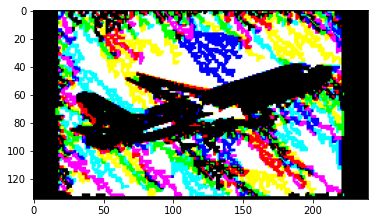

In [0]:
plt.imshow(IMplane)